In [1]:
from BOCC import load_clusters
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random

/Users/michael/miniconda3/envs/bocc/lib/python3.10/site-packages/requests/__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.7) or chardet (5.1.0)/charset_normalizer (2.0.9) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


In [2]:
def load_clusters_as_dict(file_path,prefix):
    coms = {}
    for line in open(file_path,'r'):
        line = line.strip().split()
        coms[prefix+line[0]] = line[1:]
    return coms

def remove_trivial_coms(subcoms):
    new_sub_coms = {}
    for cid in subcoms.keys():
        # count number of HP: terms
        num_hpo = sum(['HP:' in x for x in subcoms[cid]])
        if num_hpo == 0:
            continue
        if num_hpo == len(subcoms[cid]):
            continue
        if len(subcoms[cid]) < 3:
            continue
        new_sub_coms[cid] = subcoms[cid]
    return new_sub_coms


def keep_only_genes_in_subcoms(subcoms):
    new_sub_coms = {}
    for cid in subcoms.keys():
        genes = [ x for x in subcoms[cid] if 'HP:' not in x]
        new_sub_coms[cid] = genes
    return new_sub_coms

# load the 2022 clusters
g22_subcoms = load_clusters_as_dict('../SubComs/2022/paris.greedy.2022.coms.txt','paris.greedy.2022:')
w22_subcoms = load_clusters_as_dict('../SubComs/2022/paris.walktrap.2022.coms.txt','paris.walktrap.2022:')
i22_subcoms = load_clusters_as_dict('../SubComs/2022/paris.infomap.2022.coms.txt','paris.infomap.2022:')
c22_subcoms = load_clusters_as_dict('../SubComs/2022/paris.cesna.2022.coms.txt','paris.cesna.2022:')

# combine all dicts into one
all_subcoms = {}
all_subcoms.update(g22_subcoms)
all_subcoms.update(w22_subcoms)
all_subcoms.update(i22_subcoms)
all_subcoms.update(c22_subcoms)

all_subcoms = remove_trivial_coms(all_subcoms)
subcoms_genes = keep_only_genes_in_subcoms(all_subcoms)

In [3]:
lof = pd.read_csv('../Resources/gnomad_oe_lof_upper.tsv', sep='\t')
# load ../Resources/gnomad_oe_lof_upper.tsv as a dict that maps gene tp lof score
lof_dict = dict(zip(lof['gene'],lof['oe_lof_upper']))

preds = pd.read_csv('../Results/2022_predictions_cluster.tsv', sep='\t')

# filter preds to only include rows with cluster_id in subcoms_genes
preds = preds[preds['cluster_id'].isin(subcoms_genes.keys())]

In [4]:
print(lof)
print(preds)
print(lof_dict)
print(preds[preds['cluster_id'] == 'cluster'])

         gene  oe_lof_upper
0       MED13         0.030
1       NIPBL         0.032
2        SMC3         0.037
3       CNOT1         0.038
4         RLF         0.040
...       ...           ...
19699   OR7G2           NaN
19700   OR7G3           NaN
19701   OR8D1           NaN
19702  ZNF600           NaN
19703  ZNF645           NaN

[19704 rows x 2 columns]
                    cluster_id  p < 1.00  p < 0.35  p < 0.10  p < 0.05
0       paris.infomap.2022:142         0         0         0         0
1       paris.infomap.2022:153         0         0         0         0
2       paris.infomap.2022:174         0         0         0         0
3       paris.infomap.2022:193         0         0         0         1
4       paris.infomap.2022:194         0         0         0         0
...                        ...       ...       ...       ...       ...
2805  paris.walktrap.2022:1981         0         0         0         0
2806  paris.walktrap.2022:1983         0         0         0         0

In [5]:
# create a dict that maps cluster id to a list of lof scores of genes in that cluster
cluster_lof = {}
for cid in subcoms_genes.keys():
    cluster_lof[cid] = [lof_dict[x] for x in subcoms_genes[cid] if x in lof_dict]

assert len(cluster_lof) == len(subcoms_genes)



In [6]:
# add columns to preds for the mean, median, max and min lof score of genes in the cluster
def mean(x):
    if len(x) == 0:
        return -1
    return sum(x)/len(x)

def median(x):
    if len(x) == 0:
        return -1
    return sorted(x)[len(x)//2]

def max(x):
    if len(x) == 0:
        return -1
    return sorted(x)[-1]

def min(x):
    if len(x) == 0:
        return -1
    return sorted(x)[0]

preds['mean_lof'] = preds['cluster_id'].apply(lambda x: mean(cluster_lof[x]))
preds['median_lof'] = preds['cluster_id'].apply(lambda x: median(cluster_lof[x]))
preds['max_lof'] = preds['cluster_id'].apply(lambda x: max(cluster_lof[x]))
preds['min_lof'] = preds['cluster_id'].apply(lambda x: min(cluster_lof[x]))

print(preds)

                    cluster_id  p < 1.00  p < 0.35  p < 0.10  p < 0.05  \
0       paris.infomap.2022:142         0         0         0         0   
1       paris.infomap.2022:153         0         0         0         0   
2       paris.infomap.2022:174         0         0         0         0   
3       paris.infomap.2022:193         0         0         0         1   
4       paris.infomap.2022:194         0         0         0         0   
...                        ...       ...       ...       ...       ...   
2805  paris.walktrap.2022:1981         0         0         0         0   
2806  paris.walktrap.2022:1983         0         0         0         0   
2807  paris.walktrap.2022:2026         0         0         0         0   
2808  paris.walktrap.2022:2033         1         1         1         1   
2809  paris.walktrap.2022:2034         0         0         0         0   

      mean_lof  median_lof  max_lof  min_lof  
0    -1.000000      -1.000   -1.000   -1.000  
1    -1.000000   

In [7]:
# if mean_lof  median_lof  max_lof  min_lof are all -1, then remove the row
print(preds.shape)
preds = preds[(preds['mean_lof'] != -1) | (preds['median_lof'] != -1) | (preds['max_lof'] != -1) | (preds['min_lof'] != -1)]
print(preds.shape)
print(preds)

(2810, 9)
(2657, 9)
                    cluster_id  p < 1.00  p < 0.35  p < 0.10  p < 0.05  \
14      paris.infomap.2022:684         0         0         0         0   
17      paris.infomap.2022:812         1         1         1         1   
19      paris.infomap.2022:826         0         0         0         0   
20      paris.infomap.2022:827         0         0         0         0   
21      paris.infomap.2022:830         1         1         1         1   
...                        ...       ...       ...       ...       ...   
2805  paris.walktrap.2022:1981         0         0         0         0   
2806  paris.walktrap.2022:1983         0         0         0         0   
2807  paris.walktrap.2022:2026         0         0         0         0   
2808  paris.walktrap.2022:2033         1         1         1         1   
2809  paris.walktrap.2022:2034         0         0         0         0   

      mean_lof  median_lof  max_lof  min_lof  
14    0.503000       0.503    0.503    0.503

1169 1256
1259 1375
1235 1330
1266 1377
1126 1299
1221 1413
1196 1369
1226 1417
1100 1325
1158 1476
1138 1427
1160 1483
1313 1112
1383 1251
1359 1206
1384 1259


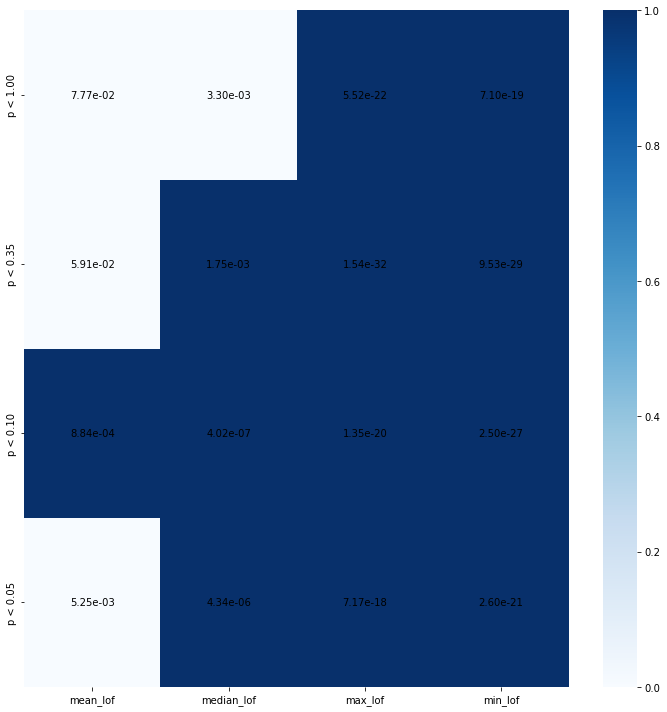

In [14]:
import scipy.stats as stats
# is there a significant difference between mean_lof in clusters with p < 1.00 and not?
def test_sig(p_col,lof_col):
    p = preds[preds[p_col] == 1][lof_col]
    pn = preds[preds[p_col] == 0][lof_col]
    # remove NaNs and Nones from p and np
    p = [x for x in p if x is not None]
    pn = [x for x in pn if x is not None]
    p = [x for x in p if not np.isnan(x)]
    pn = [x for x in pn if not np.isnan(x)]
    print(len(p),len(pn))
    # randomly downsample the majority class to the size of the minority class
    random.seed(42)
    # if len(p) > len(pn):
    #     p = random.sample(p,len(pn))
    # else:
    #     pn = random.sample(pn,len(p))
    
    # test using chi squared
    return stats.ks_2samp(p,pn)
    # return stats.ttest_ind(p,pn)

res = np.zeros((4,4))
res_binary = np.zeros((4,4))
for i,p_col in enumerate(['p < 1.00','p < 0.35','p < 0.10','p < 0.05']):
    for j,lof_col in enumerate(['mean_lof','median_lof','max_lof','min_lof']):
        s,p = test_sig(p_col,lof_col)
        if p < (0.05 / 16):
            # print(p_col,lof_col,s,p)
            pass
        res[i,j] = p
        res_binary[i,j] = p < (0.05 / 16)

# plot res as a heatmap
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
sns.heatmap(res_binary, fmt='.2e', cmap='Blues', xticklabels=['mean_lof','median_lof','max_lof','min_lof'], yticklabels=['p < 1.00','p < 0.35','p < 0.10','p < 0.05'])
# annotate the heatmap with the p values in res
for i in range(4):
    for j in range(4):
        plt.text(j+0.5,i+0.5,'{:.2e}'.format(res[i,j]),ha='center',va='center',color='black')
plt.tight_layout()
plt.savefig('../Results/2022_lof_heatmap.png', dpi=300)
plt.show()
plt.close()     


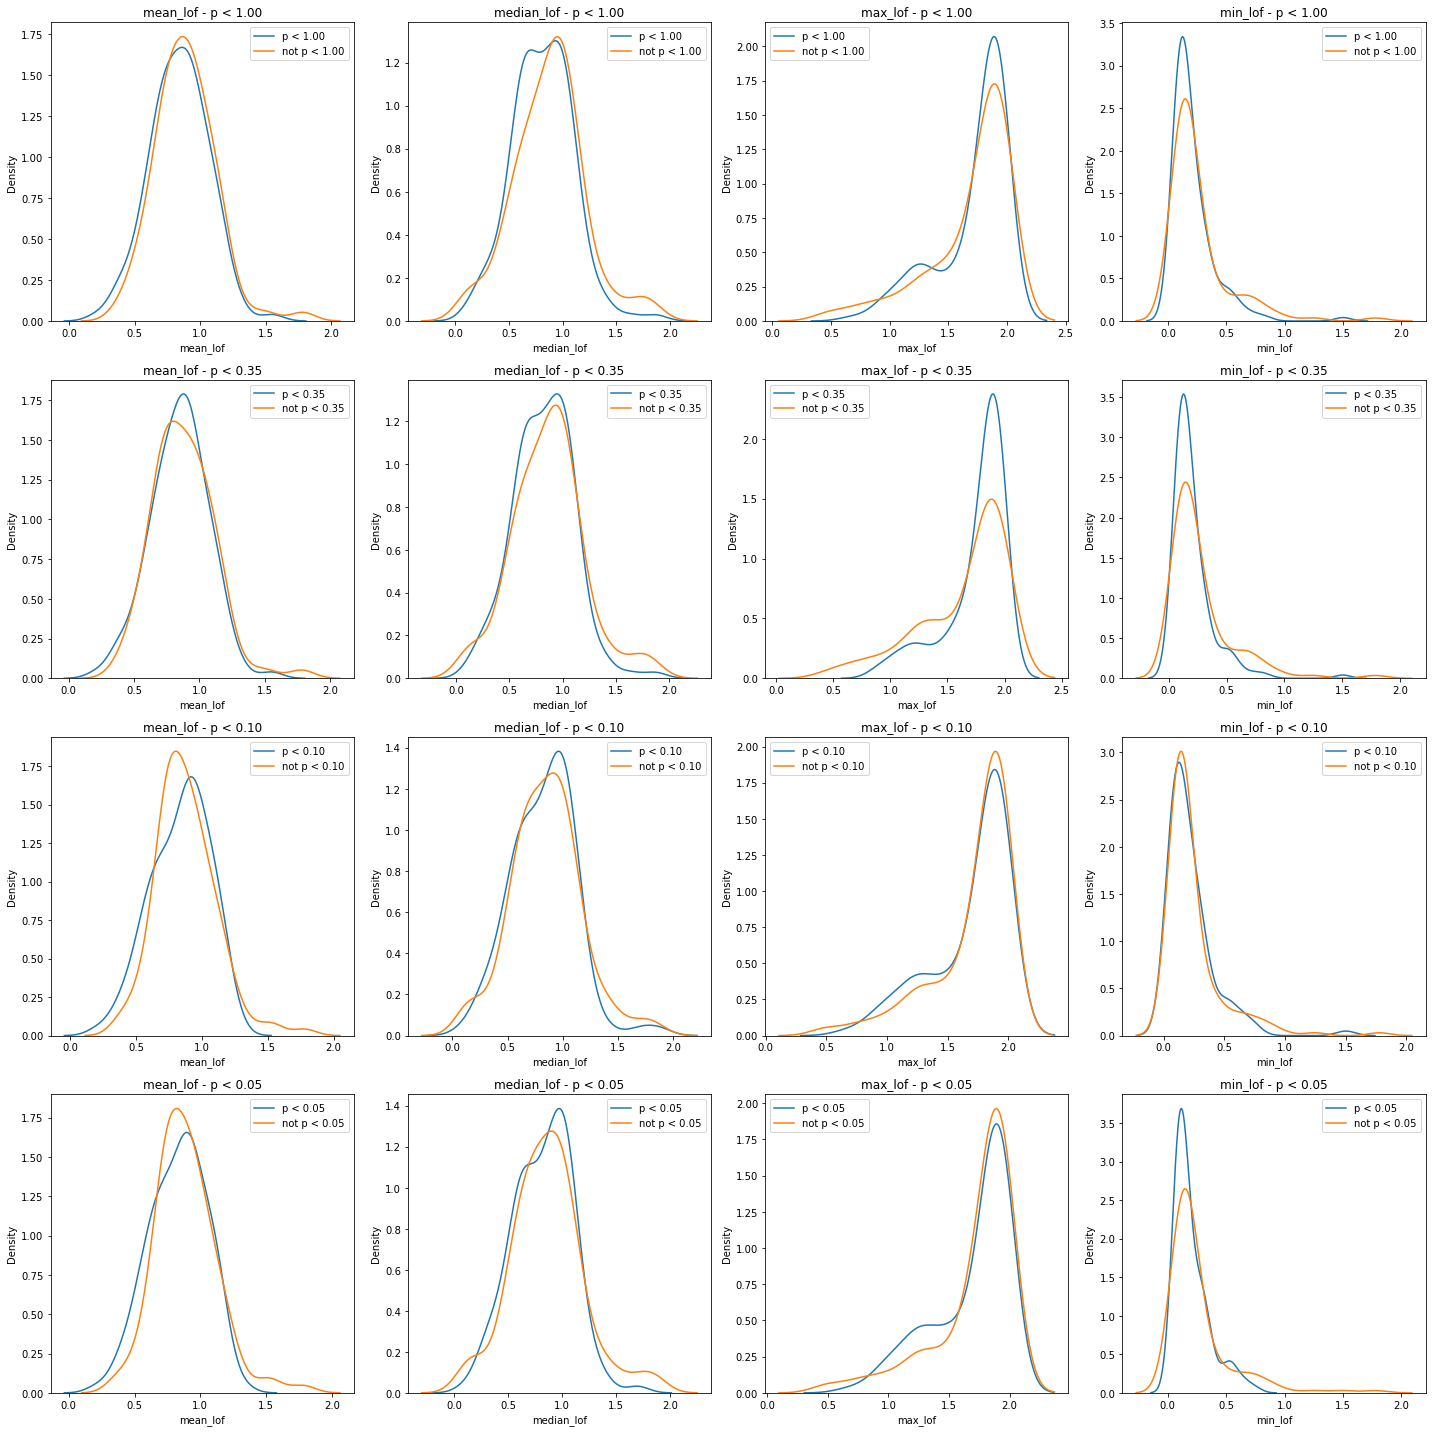

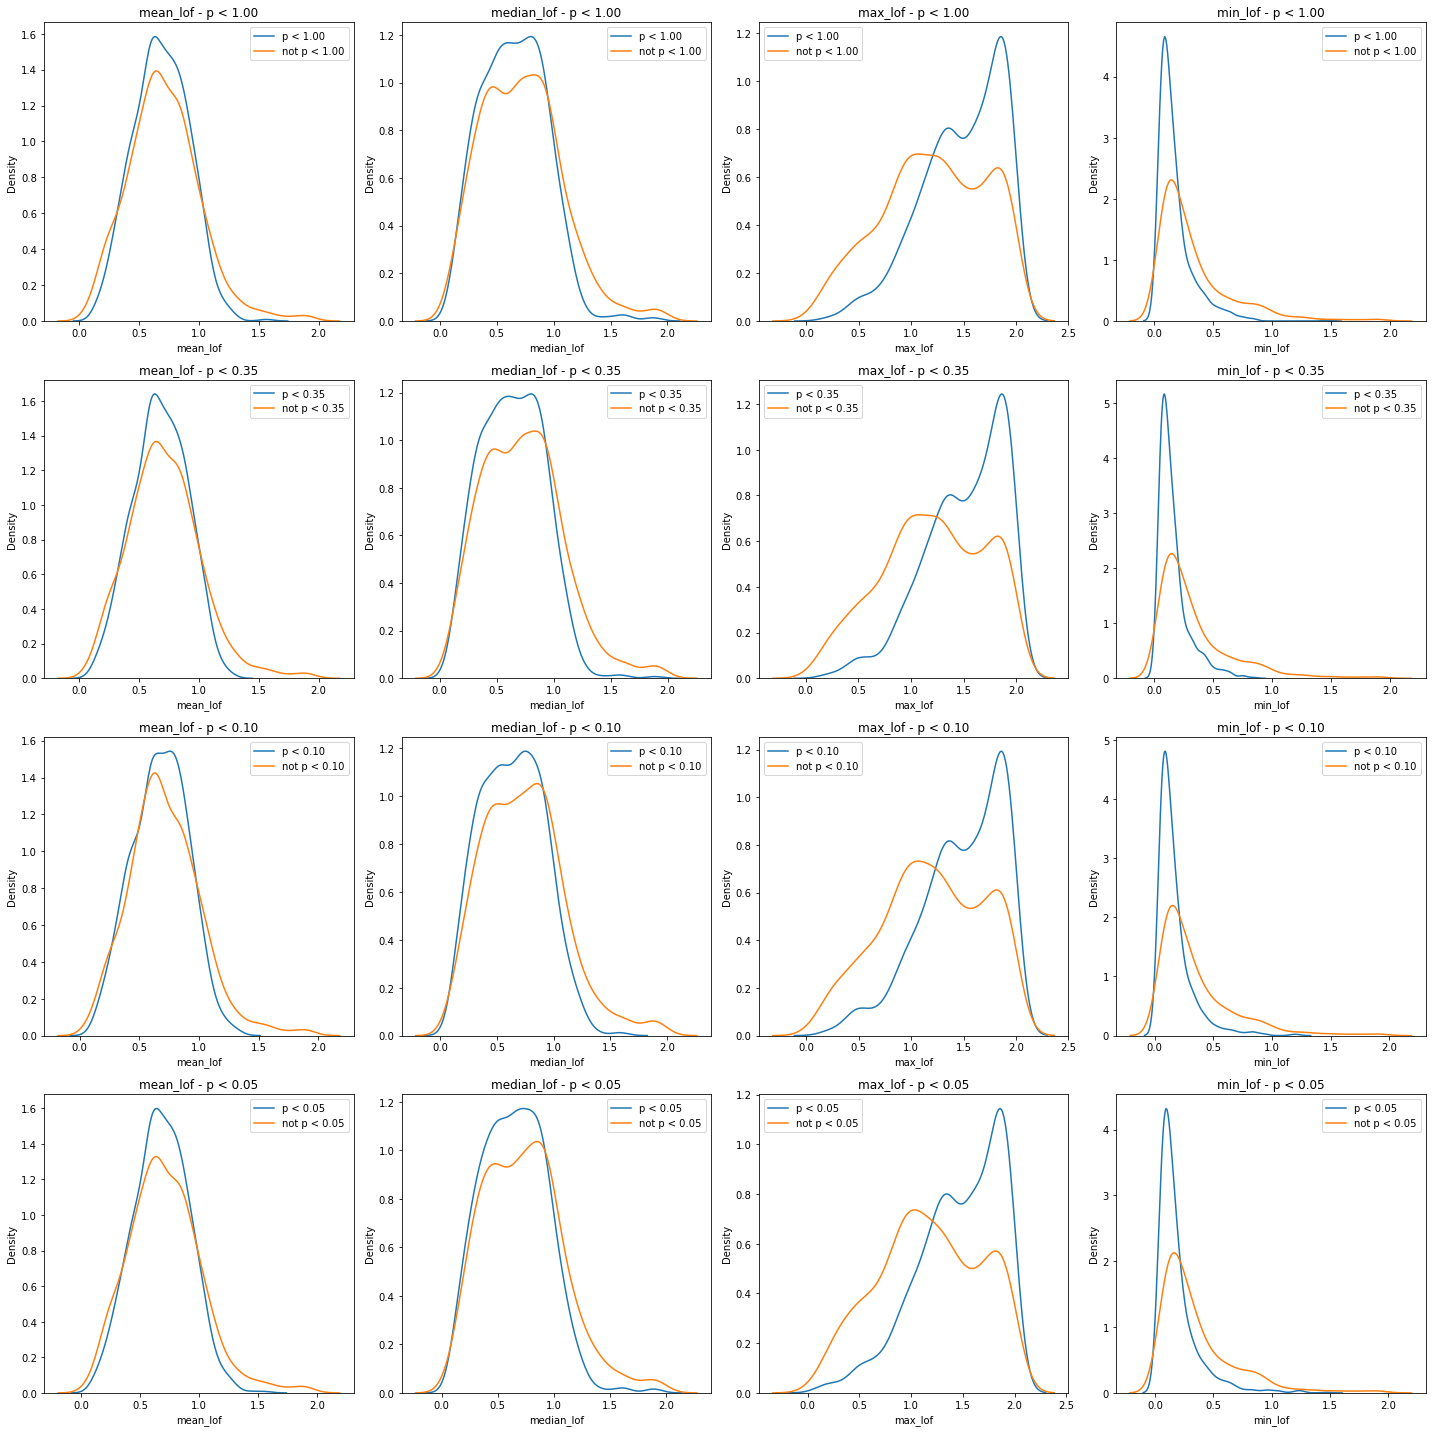

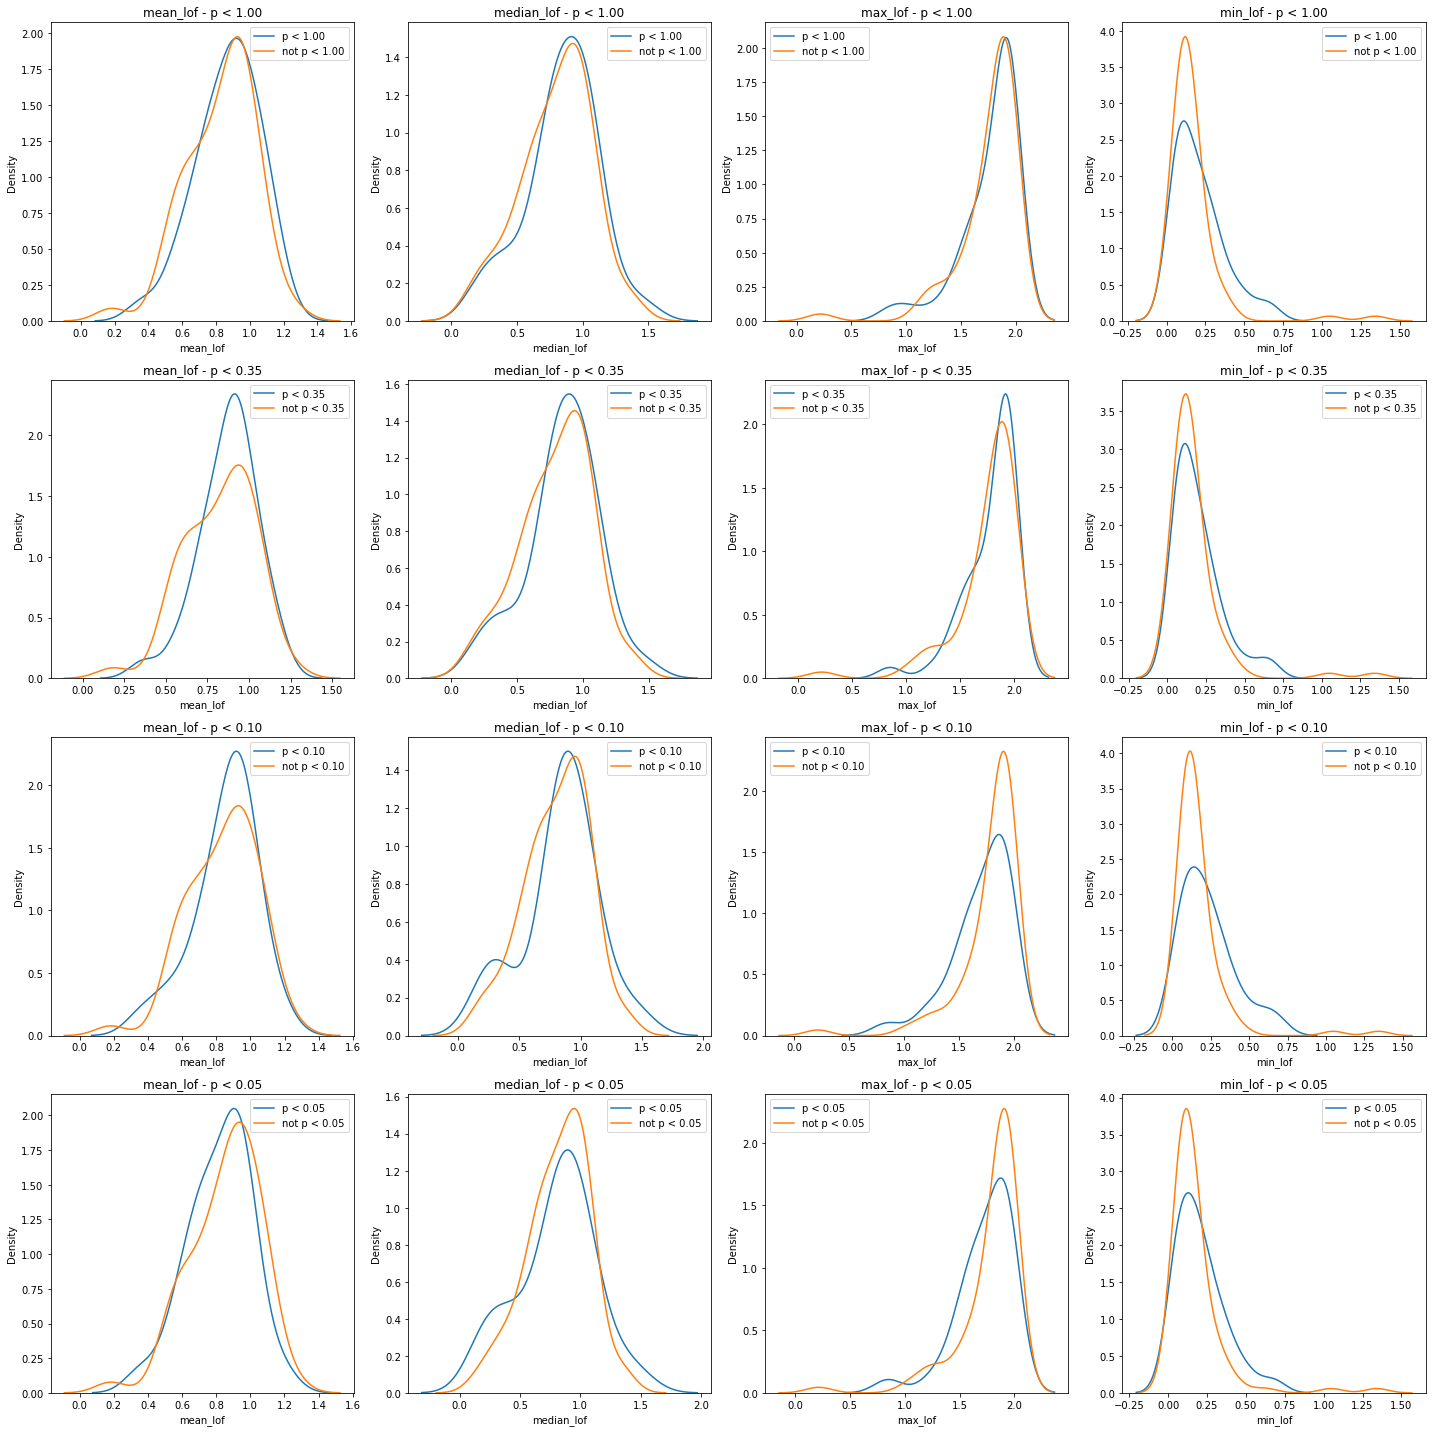

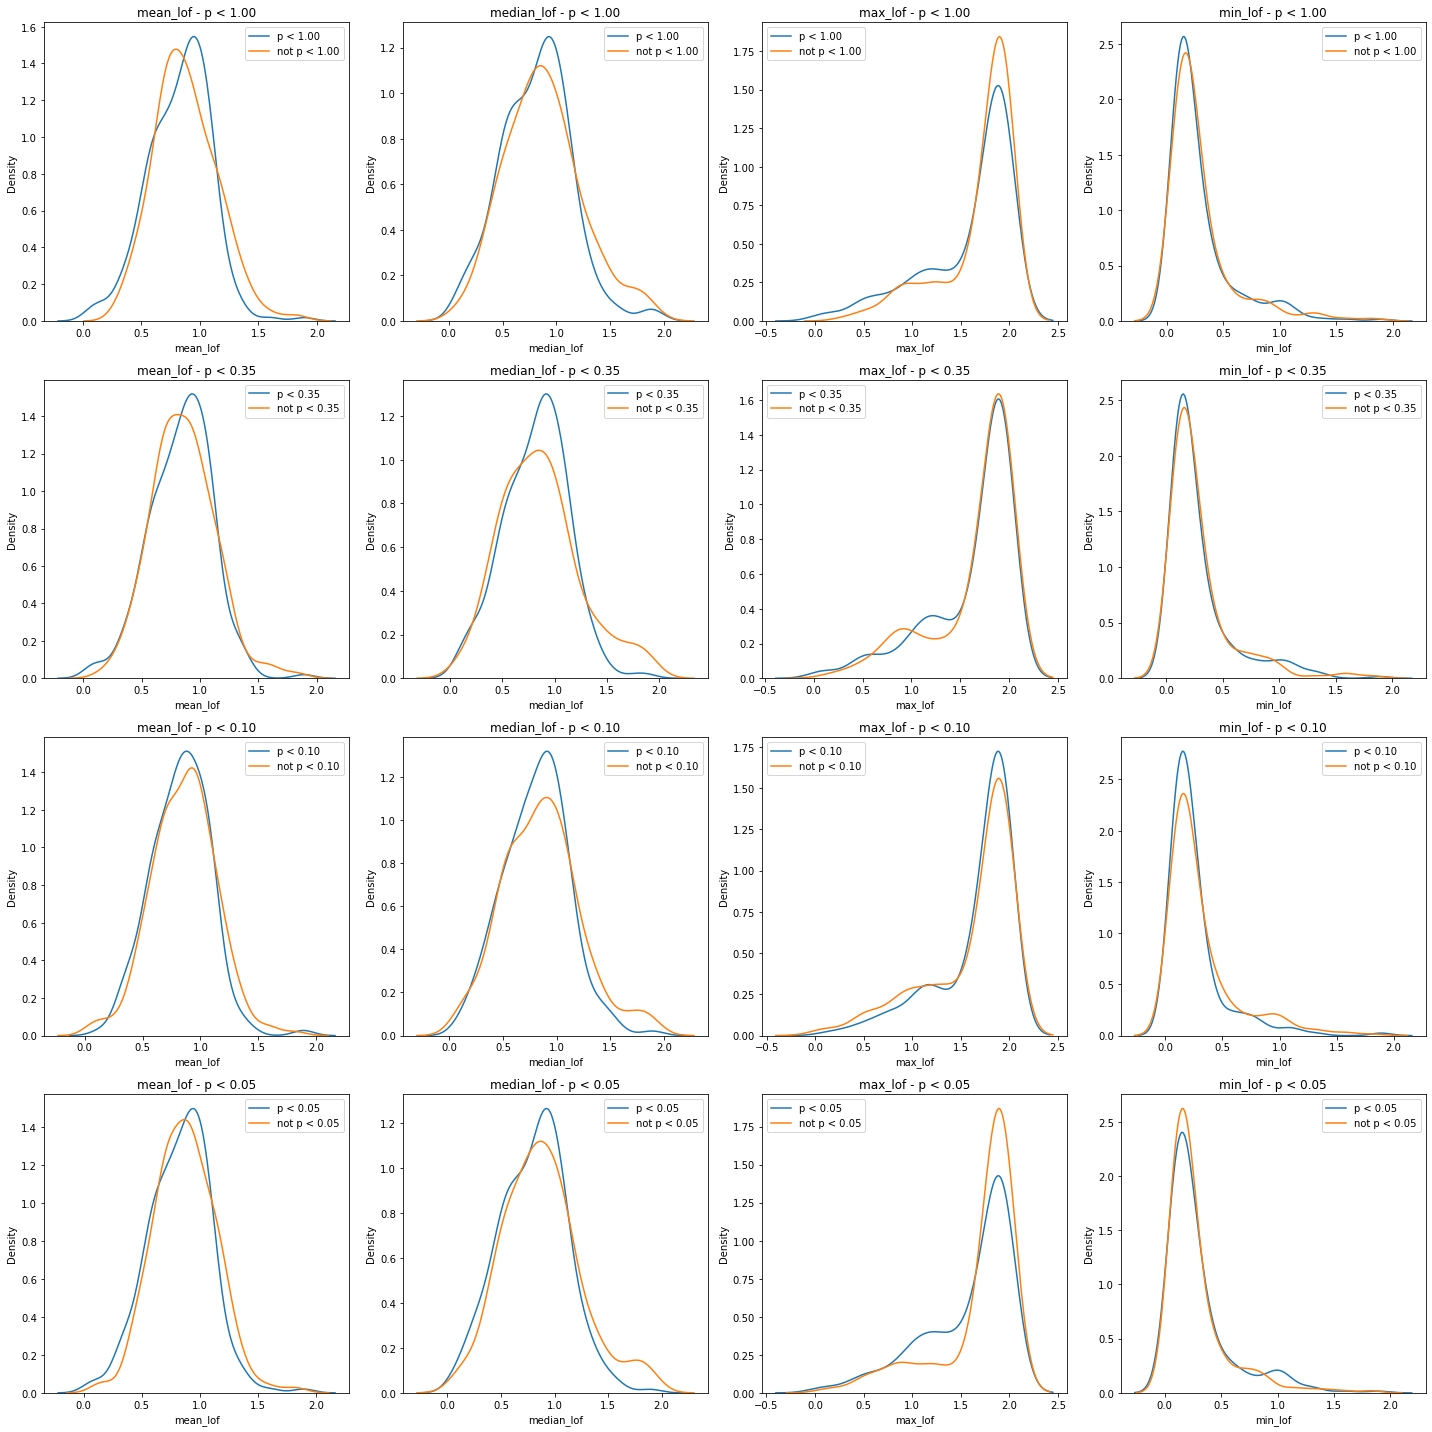

In [13]:
# add an algo column to preds
preds['algo'] = preds['cluster_id'].apply(lambda x: x.split(':')[0])


# plot the distributions
def get_vals_for_sig_testing(p_col,lof_col,df):
    p = df[df[p_col] == 1][lof_col]
    pn = df[df[p_col] == 0][lof_col]
    # remove NaNs and Nones from p and np
    p = [x for x in p if x is not None]
    pn = [x for x in pn if x is not None]
    p = [x for x in p if not np.isnan(x)]
    pn = [x for x in pn if not np.isnan(x)]
    return p,pn


for algo in preds['algo'].unique():
    df = preds[preds['algo'] == algo]
    fig, ax = plt.subplots(4,4,figsize=(20,20))
    for i,p_col in enumerate(['p < 1.00','p < 0.35','p < 0.10','p < 0.05']):
        for j,lof_col in enumerate(['mean_lof','median_lof','max_lof','min_lof']):
            p,pn = get_vals_for_sig_testing(p_col,lof_col,df)
            sns.kdeplot(p, ax=ax[i,j], label=p_col)
            sns.kdeplot(pn, ax=ax[i,j], label='not ' + p_col)
            ax[i,j].set_xlabel(lof_col)
            ax[i,j].legend()
            ax[i,j].set_title(lof_col + ' - ' + p_col)

    plt.tight_layout()
    plt.savefig('../Results/2022_lof_distributions.{}.png'.format(algo), dpi=300)
    plt.show()



In [ ]:
print((0.05 / 16))